# Importowanie bibliotek

### Dodanie ścieżki do projektu

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Imporotowanie

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from corona_analysis.utils import save, paths
from pathlib import Path
from corona_analysis.scrapers import healthdata, koronawirusunas, meteostat, policjapl, rmf24, wiki_demo, wiki_urban

# Wczytanie danych

In [3]:
df = pd.read_csv(Path(paths.get_path(), "df.csv"), index_col=0, parse_dates=True, dayfirst=True)

Sprawdzam czy w danych nie ma braków, a jeżeli są to uzupełniam je 0.

In [4]:
df.head(3)

,Unnamed: 0.1,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor,date
2020-01-01,12.0,19145.0,734.0,188.0,332.0,42.0,1.0,46.0,1.4,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-02,11.0,14654.0,513.0,333.0,166.0,60.0,5.0,67.0,0.8,-1.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-01-03,10.0,15507.0,468.0,405.0,122.0,62.0,3.0,69.0,0.5,-4.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [5]:
df.tail(3)

,Unnamed: 0.1,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor,date
2020-05-26,1.0,15783.0,562.0,281.0,144.0,48.0,3.0,54.0,13.9,8.0,...,11030.0,1024.0,10020.0,-31.65,-5.06,2171.0,78864.0,0.0,19139.0,146.0
2020-05-27,0.0,16226.0,596.0,311.0,186.0,60.0,6.0,65.0,14.8,8.0,...,11115.0,1028.0,10330.0,-31.65,-5.06,2320.0,79007.0,0.0,19682.0,147.0
2020-05-28,0.0,16226.0,596.0,311.0,186.0,60.0,6.0,65.0,15.9,8.0,...,11227.0,1038.0,10560.0,-31.65,-5.06,2248.0,79818.0,0.0,19373.0,148.0


In [6]:
woj = koronawirusunas.SUB_SITES
wojewodztwa = pd.DataFrame()
for i in range(1, len(woj)):
    dat = pd.read_csv(Path(paths.get_path(), woj[i][12:] + ".csv"), index_col=0, parse_dates=True, dayfirst=True)
    dat.fillna(axis=1, inplace=True, value=0)
    dat["wojewodztwo"] = np.nan
    dat.fillna(axis=1, inplace=True, value=woj[i][12:])
    dat["date"] = (dat.index - dat.index.min())  / np.timedelta64(1,'D')
    wojewodztwa = wojewodztwa.append(dat)

In [7]:
woj_info = pd.read_csv(Path(paths.get_path(), "woj_info.csv"), index_col=0, parse_dates=True, dayfirst=True)

In [37]:
wojewodztwa

,zar,chor,zgo,wyl,wojewodztwo,date
2020-03-14,12,0.0,0.0,0.0,slaskie,0.0
2020-03-15,14,0.0,0.0,0.0,slaskie,1.0
2020-03-16,18,0.0,0.0,0.0,slaskie,2.0
2020-03-17,24,0.0,0.0,0.0,slaskie,3.0
2020-03-18,30,0.0,0.0,0.0,slaskie,4.0
...,...,...,...,...,...,...
2020-05-24,103,18.0,0.0,85.0,lubuskie,71.0
2020-05-25,108,23.0,0.0,85.0,lubuskie,72.0
2020-05-26,111,24.0,0.0,87.0,lubuskie,73.0
2020-05-27,111,24.0,0.0,87.0,lubuskie,74.0


# Przygotowanie danych do analizy

In [8]:
df = df[df.index >= "2020-03-01"]
df['zar_log'] = np.log(df["confirmed_infections"] + 1)

In [9]:
df['daily_inf'] = df['zar'].diff(1)
df['sum'] = df["confirmed_infections"].cumsum()

## Przygowowanie danych dla Śląska

In [10]:
df['suma'] =  df['zar']
df.loc[min(wojewodztwa.index):max(wojewodztwa.index),'suma'] = df.loc[min(wojewodztwa.index):max(wojewodztwa.index)]['suma'] - wojewodztwa[wojewodztwa.wojewodztwo == "slaskie"].zar
df['diff'] = df['suma'].diff(1)

# Analiza

In [11]:
df.columns

Index(['Unnamed: 0.1', 'Interwencje', 'Zatrzymani na gorącym uczynku',
       'Zatrzymani poszukiwani', 'Zatrzymani nietrzeźwi kierujący',
       'Wypadki drogowe', 'Zabici w wypadkach', 'Ranni w wypadkach',
       'temperature', 'temperature_min', 'temperature_max', 'winddirection',
       'windspeed', 'pressure', 'allbed_mean', 'ICUbed_mean', 'deaths_mean',
       'admis_mean', 'newICU_mean', 'totdea_mean', 'bedover_mean',
       'icuover_mean', 'mobility_composite', 'total_tests',
       'confirmed_infections', 'smp', 'testy', 'testyl', 'zar', 'chor', 'zgo',
       'wyl', 'pieszo', 'pojazdem', 'hosp', 'kwar', 'kwar_z', 'nadzor', 'date',
       'zar_log', 'daily_inf', 'sum', 'suma', 'diff'],
      dtype='object')

## Wykresy dla całego kraju

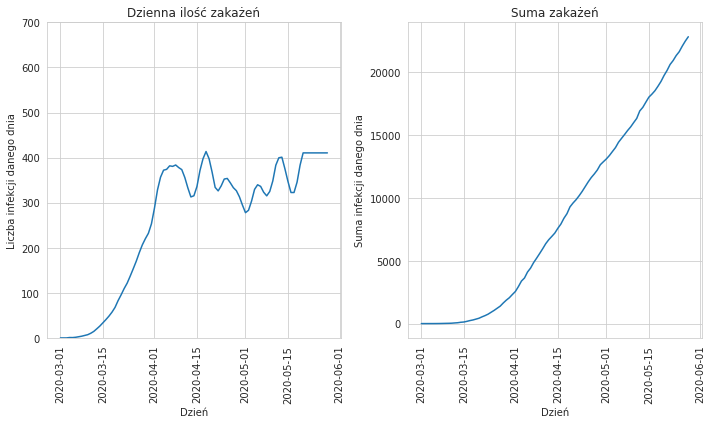

In [12]:
from matplotlib import pyplot as plt

sns.set_style("whitegrid")

plt.figure(figsize=(10,6))

ax1 = plt.subplot(121)

sns.lineplot(x='index', y='confirmed_infections', data=df.reset_index(), legend=False, ax=ax1)
ax1.set(ylabel='Liczba infekcji danego dnia', xlabel='Dzień')
ax1.set_title("Dzienna ilość zakażeń")
ax1.set_ylim([0,700])
plt.xticks(rotation = 'vertical')

ax2 = plt.subplot(122)
sns.lineplot(x='index', y='zar', data=df.reset_index(), legend=False, ax=ax2)
ax2.set(ylabel='Suma infekcji danego dnia', xlabel='Dzień')
ax2.set_title("Suma zakażeń")
plt.xticks(rotation = 'vertical')


plt.tight_layout()

plt.savefig("../img/dane_marzec.png", dpi=200)

Dane przedstawione na poniższych wykresach obejmują okres: 01.03.2020 - 19.05.2020

## Wykresu porównujące IHME i koronawirusunas

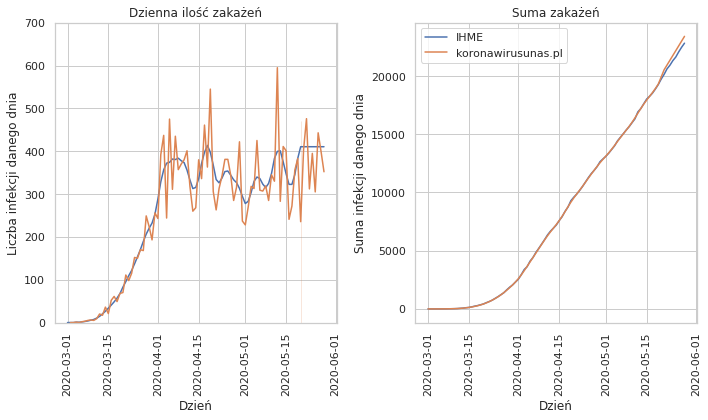

In [54]:
sns.set_style("whitegrid")

plt.figure(figsize=(10,6))


# First plot
ax1 = plt.subplot(121)

sns.lineplot(x='index', y='confirmed_infections', data=df.reset_index(), ax=ax1)
ax1.set(ylabel='Liczba infekcji danego dnia', xlabel='Dzień')
ax1.set_title("Dzienna ilość zakażeń")

sns.lineplot(x='index', y='daily_inf', data=df.reset_index(), ax=ax1)
ax1.set(ylabel='Liczba infekcji danego dnia', xlabel='Dzień')
ax1.set_title("Dzienna ilość zakażeń")
ax1.set_ylim([0,700])
plt.xticks(rotation = 'vertical')


# Second plot
ax2 = plt.subplot(122)
sns.lineplot(x='index', y='zar', data=df.reset_index(), legend=False, ax=ax2)
ax2.set(ylabel='Suma infekcji danego dnia', xlabel='Dzień')
ax2.set_title("Suma zakażeń")
plt.xticks(rotation = 'vertical')

ax2 = plt.subplot(122)
sns.lineplot(x='index', y='sum', data=df.reset_index(), legend=False, ax=ax2)
ax2.set(ylabel='Suma infekcji danego dnia', xlabel='Dzień')

plt.legend(["IHME", "koronawirusunas.pl"])
plt.tight_layout()

plt.savefig("../img/dane_marzec_porownanie.png", dpi=200)

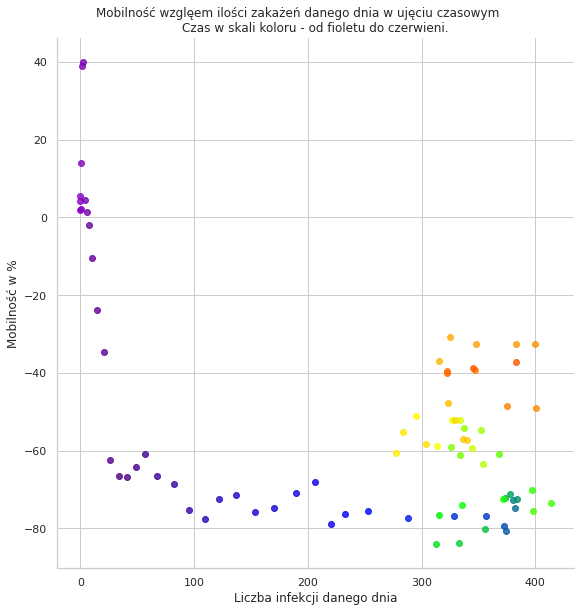

In [56]:
ax = sns.lmplot(x='confirmed_infections', y='pieszo', hue='date', data=df[df.index < "2020-05-20"], palette=sns.blend_palette(colors=("#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"),n_colors=len(df['date'])), legend=False, height = 8)
ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
plt.title("Mobilność wzglęem ilości zakażeń danego dnia w ujęciu czasowym \
        \nCzas w skali koloru - od fioletu do czerwieni.")
plt.show()

Na wykresie znajdują się dane od momentu wystąpienia pierwszych przypadków koronawirusa w polsce. W miarę upływu czasu pomimo spadku
mobilności ludności, ilość zachorowań ustabilizowała się na poziomie ~350/dzień. Na wykresie widać pewne fazy (gwałtowne przeskoki
między kolejnymi poziomami mobilności). Na następnym wykresie dane zotały podzielone na grupy względem odchylenia standardowego.

/home/pk/miniconda3/envs/corona-analysis-1/lib/python3.8/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


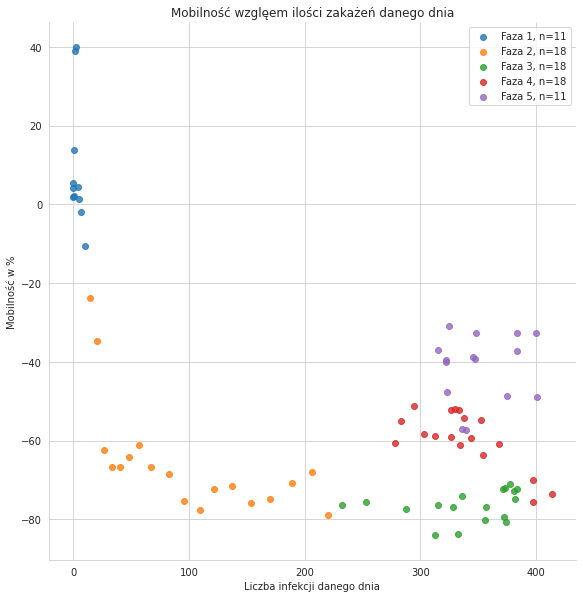

In [16]:
df.loc[0:11,'label'] = 0
df.loc[11:,'label'] = 1
df.loc[29:,'label'] = 2
df.loc[47:,'label'] = 3
df.loc[65:,'label'] = 4
ax = sns.lmplot(x="confirmed_infections", y="pieszo", data=df[df.index < "2020-05-20"], fit_reg= False, height = 8, hue = "label", legend = False)
ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
plt.legend(labels=['Faza 1, n=11', 'Faza 2, n=18', 'Faza 3, n=18', 'Faza 4, n=18', 'Faza 5, n=11'])
plt.title("Mobilność wzglęem ilości zakażeń danego dnia")
plt.show()

Dane podzielone zostały na 5 Faz. Charakteryzują się one pewnymi podobnymi cechami, które wydoczne są także poniżej w danych statystycznych. Każda z grup składa się z około 11-18 punktów (dni). 3 Ostatnie fazy są szczególnie podobne do siebie, ich sd w mobilności jest niemalże identyczne i wynosi ~5, podobnie jest w kolmnie infekcje ~31.

In [17]:
df.groupby('label').agg(np.std)['confirmed_infections']

label
0.0     3.424840
1.0    67.014140
2.0    45.369417
3.0    38.238815
4.0    37.303563
Name: confirmed_infections, dtype: float64

In [18]:
df.groupby('label').agg(np.std)['pieszo']

label
0.0    16.133486
1.0    14.297152
2.0     3.877869
3.0     7.243015
4.0     8.911826
Name: pieszo, dtype: float64

In [19]:
df.groupby('label').agg(len)['pieszo']

label
0.0    11
1.0    18
2.0    18
3.0    18
4.0    25
Name: pieszo, dtype: int64

In [20]:
df.groupby('label').agg(np.mean)['pieszo']

label
0.0     9.066364
1.0   -65.560556
2.0   -76.538889
3.0   -59.616111
4.0   -37.704400
Name: pieszo, dtype: float64

In [21]:
df.groupby('label').agg(np.mean)['confirmed_infections']

label
0.0      2.949136
1.0     99.690085
2.0    340.336432
3.0    338.125863
4.0    374.900424
Name: confirmed_infections, dtype: float64

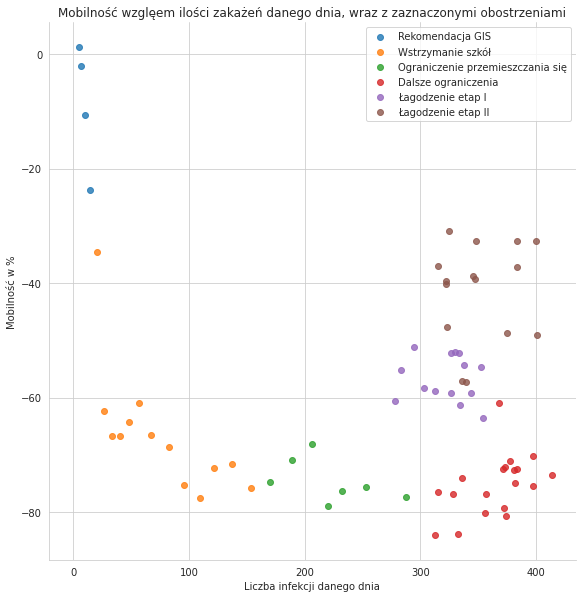

In [22]:
df.loc[df.index > "2020-03-8",'faza'] = 0
df.loc[df.index > "2020-03-12",'faza'] = 1
df.loc[df.index > "2020-03-25",'faza'] = 2
df.loc[df.index > "2020-04-01",'faza'] = 3
df.loc[df.index > "2020-04-20",'faza'] = 4
df.loc[df.index > "2020-05-04",'faza'] = 5
ax = sns.lmplot(x="confirmed_infections", y="pieszo", data=df[df.index < "2020-05-20"], fit_reg= False, height = 8, hue = "faza", legend = False)
ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
plt.legend(labels=['Rekomendacja GIS', 'Wstrzymanie szkół', 'Ograniczenie przemieszczania się','Dalsze ograniczenia','Łagodzenie etap I', 'Łagodzenie etap II'])
plt.title("Mobilność wzglęem ilości zakażeń danego dnia, wraz z zaznaczonymi obostrzeniami")
plt.show()

## Wykresy nie wliczając Śląska

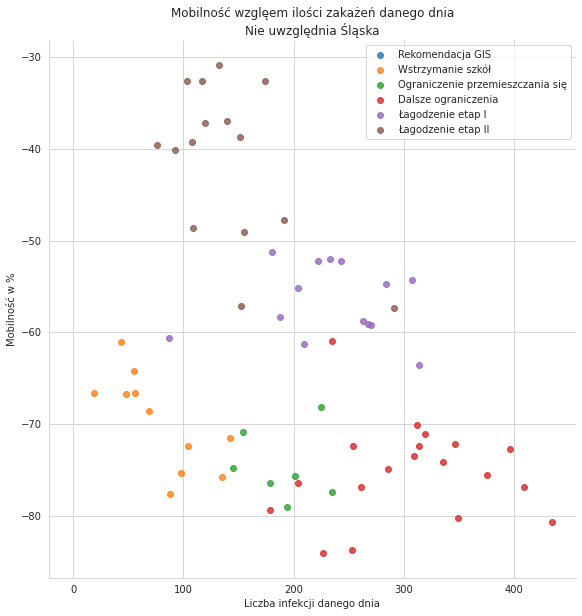

In [23]:
ax = sns.lmplot(x="diff", y="pieszo", data=df[df.index < "2020-05-20"], fit_reg= False, height = 8, hue = "faza", legend = False)
ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
plt.legend(labels=['Rekomendacja GIS', 'Wstrzymanie szkół', 'Ograniczenie przemieszczania się','Dalsze ograniczenia','Łagodzenie etap I', 'Łagodzenie etap II'], loc=1)
plt.title("Mobilność wzglęem ilości zakażeń danego dnia\nNie uwzględnia Śląska")
plt.show()

## Wykresy łączone

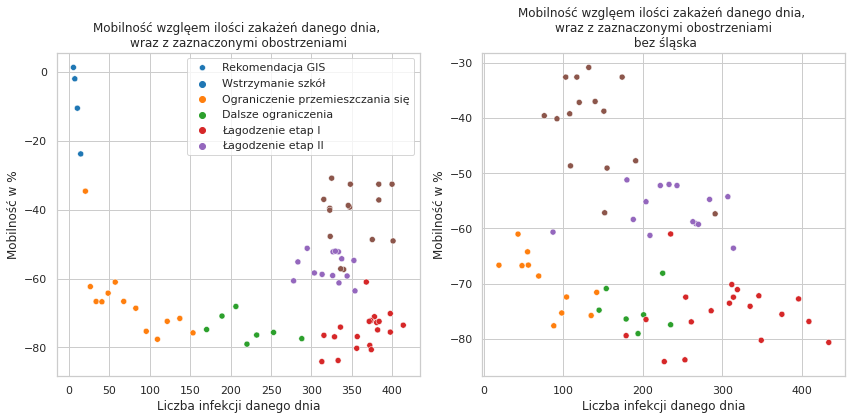

In [87]:
plt.figure(figsize=(12,6))


# First plot
ax1 = plt.subplot(121)

sns.scatterplot(x="confirmed_infections", y="pieszo", data=df[df.index < "2020-05-20"], hue = "faza", palette=sns.color_palette('tab10', 6), legend='full')
ax1.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
ax1.legend(labels=['Rekomendacja GIS', 'Wstrzymanie szkół', 'Ograniczenie przemieszczania się','Dalsze ograniczenia','Łagodzenie etap I', 'Łagodzenie etap II'])
ax1.set_title("Mobilność wzglęem ilości zakażeń danego dnia, \nwraz z zaznaczonymi obostrzeniami")

# Second plot
ax2 = plt.subplot(122)

sns.scatterplot(ax = ax2, x="diff", y="pieszo", data=df[df.index < "2020-05-20"], hue = "faza", palette=sns.color_palette('tab10', 6), legend=False)
ax2.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
ax2.set_title("Mobilność wzglęem ilości zakażeń danego dnia, \nwraz z zaznaczonymi obostrzeniami\n bez śląska")

plt.tight_layout()

plt.savefig("../img/fazy_porownanie.png", dpi=200)

## Ilość policyjnych interwencji podczas pandemii

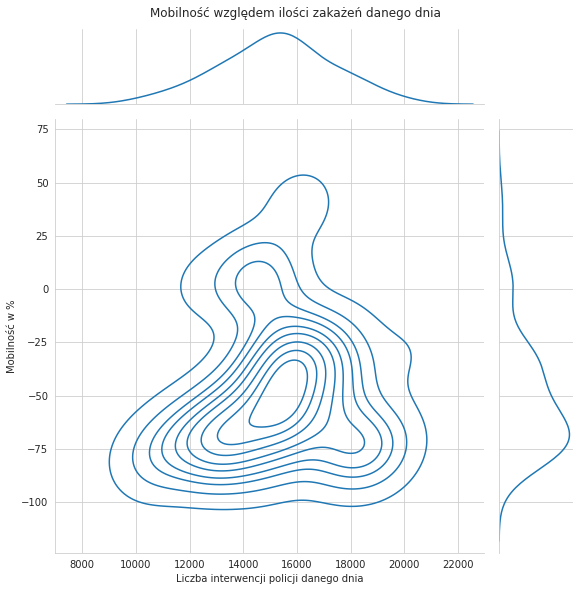

In [24]:
ax = sns.jointplot(y="pieszo", x="Interwencje", data=df, height = 8, kind="kde")
ax.set_axis_labels(ylabel='Mobilność w %', xlabel='Liczba interwencji policji danego dnia')
plt.suptitle("Mobilność względem ilości zakażeń danego dnia", y = 1.02)
plt.show()

## Ilość wypadków drogowych podczas pandemii

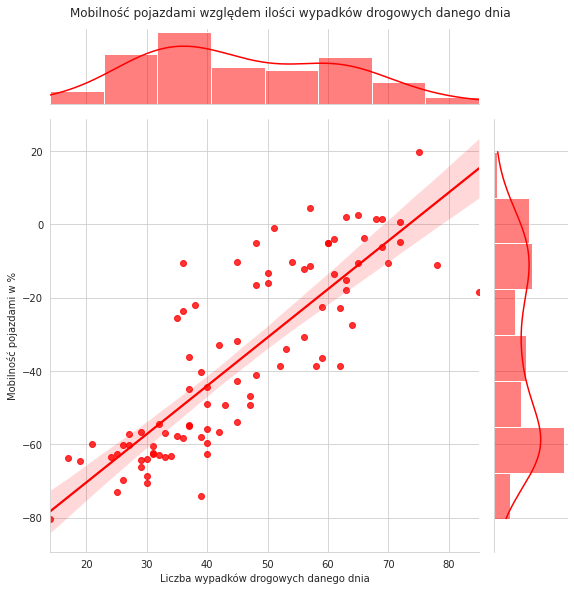

In [25]:
ax = sns.jointplot(y="pojazdem", x="Wypadki drogowe", data=df, height = 8, kind = "reg", color = "r")
ax.set_axis_labels(ylabel='Mobilność pojazdami w %', xlabel='Liczba wypadków drogowych danego dnia')
plt.suptitle("Mobilność pojazdami względem ilości wypadków drogowych danego dnia", y = 1.02)
plt.show()

## Ilość zarażonych w województwach względem danych demograficznych i urbanizacji

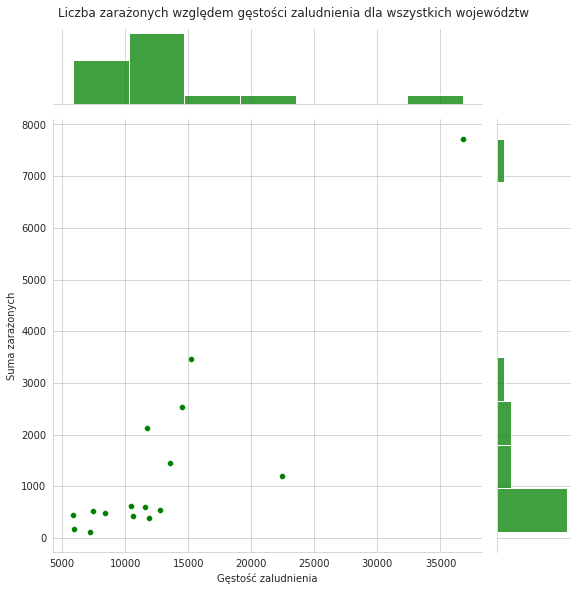

In [26]:
ax = sns.jointplot(x="gestosc_zal", y="zar", data=woj_info, height = 8, color="g")
ax.set_axis_labels(ylabel='Suma zarażonych', xlabel='Gęstość zaludnienia')
plt.suptitle("Liczba zarażonych względem gęstości zaludnienia dla wszystkich województw", y = 1.02)
plt.show()

In [27]:
woj_info.columns

Index(['wojewodztwo', 'powierzchnina', 'ludnosc', 'gestosc_zal', 'urbanizacja',
       'stopa_bezrobocia', 'pdb_na_miesz', 'miasta', 'powiaty', 'm_powiaty',
       'gminy_ogolem', 'miejskie', 'wiejskie', 'miejsko_wiejskie', 'zar',
       'chor', 'zgo', 'wyl', 'date'],
      dtype='object')

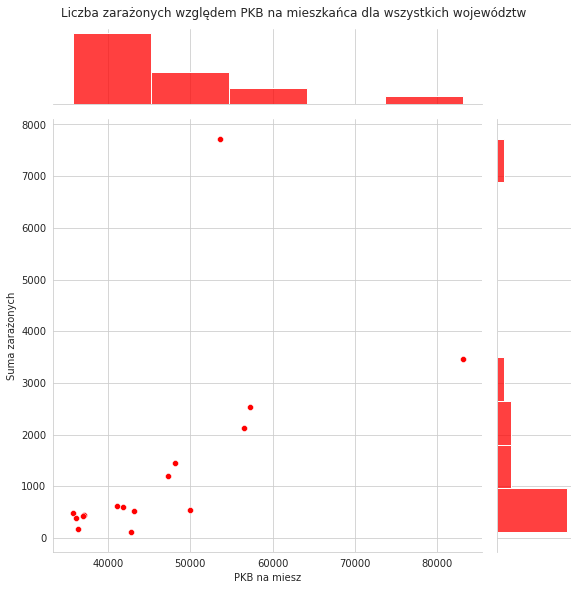

In [28]:
ax = sns.jointplot(x="pdb_na_miesz", y="zar", data=woj_info, height = 8, color="r")
ax.set_axis_labels(ylabel='Suma zarażonych', xlabel='PKB na miesz')
plt.suptitle("Liczba zarażonych względem PKB na mieszkańca dla wszystkich województw", y = 1.02)
plt.show()

In [29]:
woj_info['zar']

0     2530
1      595
2      484
3      113
4     1458
5     1190
6     3461
7      624
8      380
9      442
10     548
11    7728
12     432
13     179
14    2133
15     527
Name: zar, dtype: int64

# Pozostałe wykresy

## Zakażenia w województwach

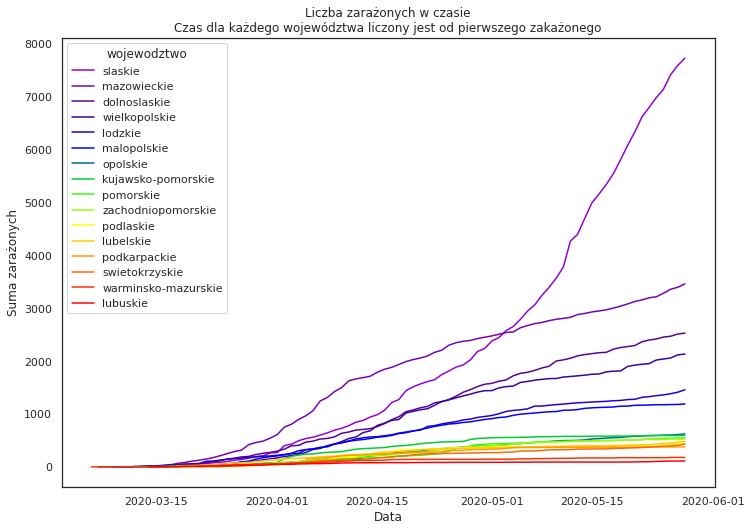

In [42]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
ax = sns.lineplot(x = "index", y = "zar", data = wojewodztwa.reset_index(), hue = "wojewodztwo", legend='brief', palette=sns.blend_palette(colors=("#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"),n_colors=16))
ax.set(ylabel='Suma zarażonych', xlabel='Data')
plt.title("Liczba zarażonych w czasie\nCzas dla każdego województwa liczony jest od pierwszego zakażonego")
plt.savefig("../img/zar_woj.png", dpi=200)

## Wykresy sumy zakażeń w Polsce

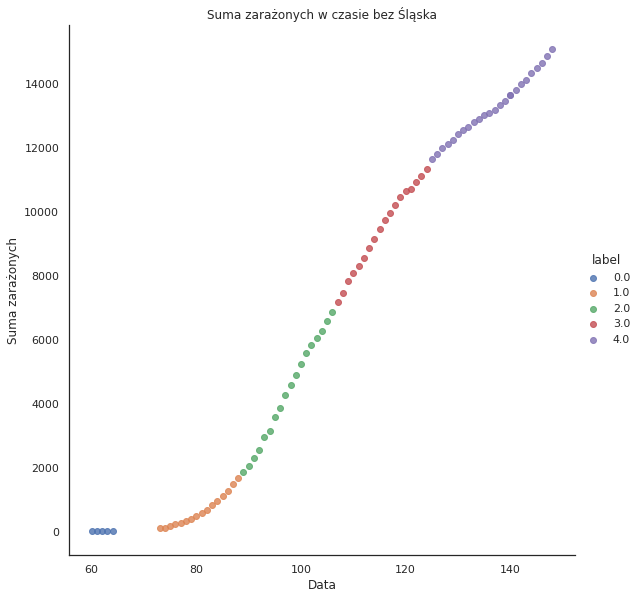

In [31]:
ax = sns.lmplot(y="suma", x="date", data=df, fit_reg= False, height = 8, hue = "label")
ax.set(ylabel='Suma zarażonych', xlabel='Data')
plt.title("Suma zarażonych w czasie bez Śląska")
plt.show()

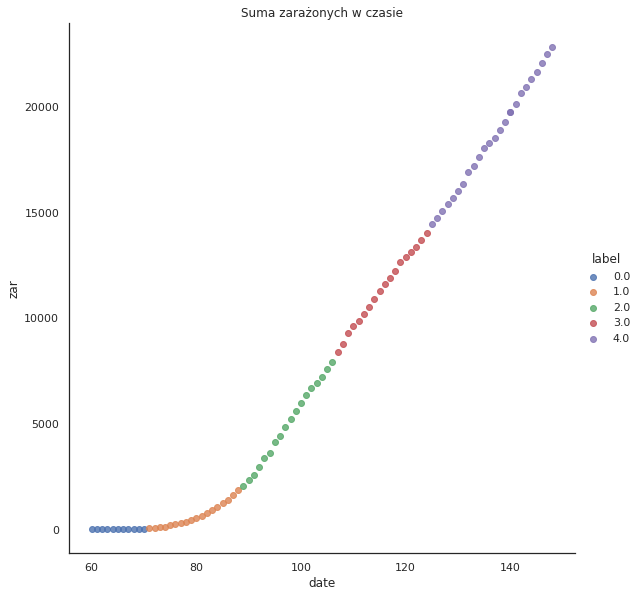

In [32]:
sns.lmplot(y="zar", x="date", data=df, fit_reg= False, height = 8, hue = "label")
ax.set(ylabel='Suma zarażonych', xlabel='Data')
plt.title("Suma zarażonych w czasie")
plt.show()

In [33]:
df.columns

Index(['Unnamed: 0.1', 'Interwencje', 'Zatrzymani na gorącym uczynku',
       'Zatrzymani poszukiwani', 'Zatrzymani nietrzeźwi kierujący',
       'Wypadki drogowe', 'Zabici w wypadkach', 'Ranni w wypadkach',
       'temperature', 'temperature_min', 'temperature_max', 'winddirection',
       'windspeed', 'pressure', 'allbed_mean', 'ICUbed_mean', 'deaths_mean',
       'admis_mean', 'newICU_mean', 'totdea_mean', 'bedover_mean',
       'icuover_mean', 'mobility_composite', 'total_tests',
       'confirmed_infections', 'smp', 'testy', 'testyl', 'zar', 'chor', 'zgo',
       'wyl', 'pieszo', 'pojazdem', 'hosp', 'kwar', 'kwar_z', 'nadzor', 'date',
       'zar_log', 'daily_inf', 'sum', 'suma', 'diff', 'label', 'faza'],
      dtype='object')

# Ploty do prezentacji

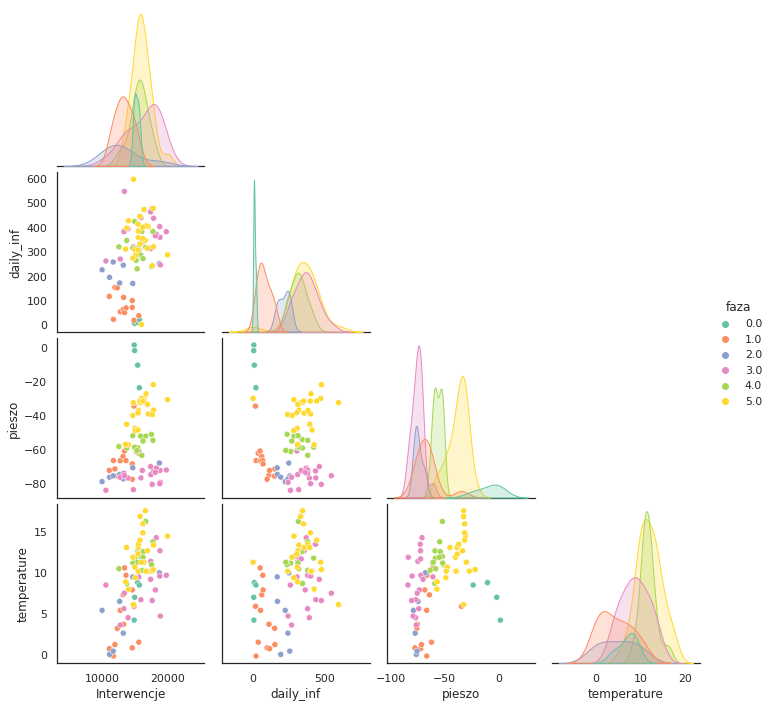

In [36]:
sns.pairplot(df.loc[:, ["faza", "Interwencje", "daily_inf", "pieszo", "temperature"]], kind="scatter", hue="faza", palette="Set2", corner = True)

<AxesSubplot:>

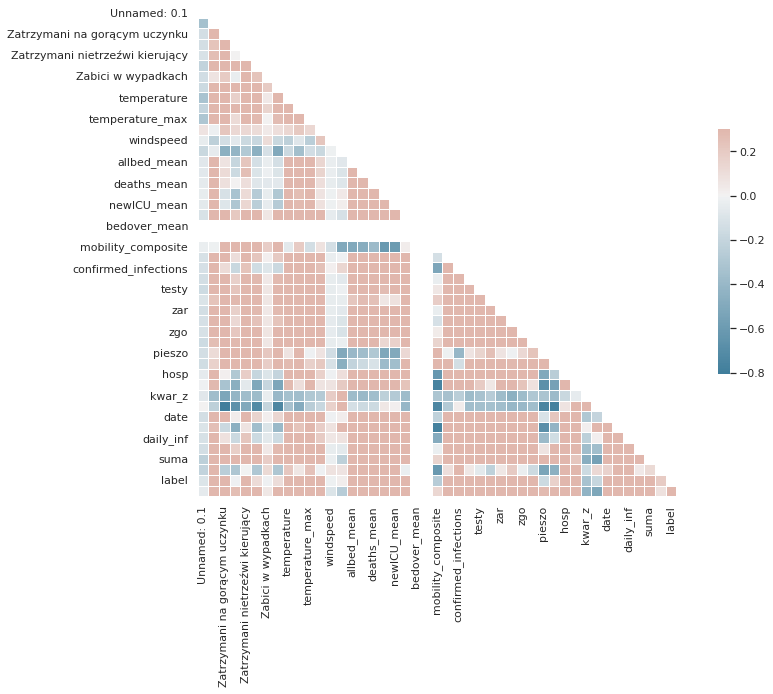

In [43]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [44]:
corr

,Unnamed: 0.1,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,kwar_z,nadzor,date,zar_log,daily_inf,sum,suma,diff,label,faza
Unnamed: 0.1,1.000000,-0.347566,-0.132224,-0.135616,-0.106207,-0.211303,-0.141535,-0.168731,-0.325886,-0.205929,...,-0.073564,0.001933,-0.132545,-0.101256,-0.118169,-0.140532,-0.238978,-0.211135,-0.091196,-0.054661
Interwencje,-0.347566,1.000000,0.333360,0.232673,0.264648,0.345370,0.066993,0.300416,0.564091,0.417508,...,-0.367280,-0.231459,0.339444,0.257868,0.352773,0.338635,0.385424,0.333969,0.345329,0.382792
Zatrzymani na gorącym uczynku,-0.132224,0.333360,1.000000,0.597783,0.740480,0.741218,0.197195,0.740181,0.468797,0.632146,...,-0.523323,-0.806030,0.443074,-0.171460,0.082779,0.588595,0.719168,-0.248868,0.388582,0.634346
Zatrzymani poszukiwani,-0.135616,0.232673,0.597783,1.000000,0.004039,0.678776,-0.035771,0.665502,0.174567,0.324636,...,-0.420730,-0.670625,0.028550,-0.456068,-0.172375,0.177793,0.340221,-0.306324,-0.009986,0.262383
Zatrzymani nietrzeźwi kierujący,-0.106207,0.264648,0.740480,0.004039,1.000000,0.405915,0.315277,0.413550,0.433116,0.485346,...,-0.368302,-0.505811,0.428709,0.067021,0.218431,0.497619,0.560982,-0.006188,0.385032,0.513449
Wypadki drogowe,-0.211303,0.345370,0.741218,0.678776,0.405915,1.000000,0.237352,0.966850,0.361889,0.503248,...,-0.369721,-0.712756,0.154746,-0.364779,-0.165160,0.297582,0.500444,-0.298236,0.115636,0.343087
Zabici w wypadkach,-0.141535,0.066993,0.197195,-0.035771,0.315277,0.237352,1.000000,0.195963,0.048218,0.149405,...,-0.035122,-0.197597,0.014630,-0.096938,-0.062368,0.048826,0.181307,0.122298,-0.008177,0.052510
Ranni w wypadkach,-0.168731,0.300416,0.740181,0.665502,0.413550,0.966850,0.195963,1.000000,0.335327,0.494945,...,-0.402979,-0.739185,0.137691,-0.393452,-0.159232,0.285423,0.472815,-0.305688,0.102240,0.367817
temperature,-0.325886,0.564091,0.468797,0.174567,0.433116,0.361889,0.048218,0.335327,1.000000,0.834987,...,-0.344668,-0.336027,0.678432,0.450246,0.493543,0.688516,0.699961,0.214622,0.641621,0.663308
temperature_min,-0.205929,0.417508,0.632146,0.324636,0.485346,0.503248,0.149405,0.494945,0.834987,1.000000,...,-0.363589,-0.484834,0.611254,0.235027,0.351343,0.667990,0.724401,0.057556,0.555664,0.670487


# ARIMA

In [45]:
from pandas.plotting import autocorrelation_plot

In [49]:
df

,Unnamed: 0.1,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,kwar_z,nadzor,date,zar_log,daily_inf,sum,suma,diff,label,faza
2020-03-01,12.0,12221.0,583.0,186.0,208.0,51.0,3.0,64.0,7.4,4.7,...,0.0,0.0,60.0,0.000000,NaN,0.000000,0.0,NaN,0.0,NaN
2020-03-02,11.0,14533.0,612.0,338.0,166.0,68.0,5.0,73.0,4.8,2.0,...,0.0,0.0,61.0,0.000000,0.0,0.000000,0.0,0.0,0.0,NaN
2020-03-03,10.0,14370.0,514.0,404.0,149.0,69.0,1.0,88.0,6.5,1.3,...,0.0,0.0,62.0,0.000000,0.0,0.000000,0.0,0.0,0.0,NaN
2020-03-04,9.0,14200.0,564.0,384.0,134.0,63.0,6.0,69.0,5.3,4.2,...,0.0,4540.0,63.0,0.626567,1.0,0.871175,1.0,1.0,0.0,NaN
2020-03-05,8.0,14677.0,604.0,384.0,145.0,57.0,3.0,71.0,3.8,-2.4,...,0.0,5647.0,64.0,0.569623,0.0,1.638775,1.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-24,3.0,13749.0,630.0,166.0,284.0,50.0,10.0,66.0,13.0,8.0,...,0.0,19529.0,144.0,6.019801,395.0,21769.707824,14344.0,210.0,4.0,5.0
2020-05-25,2.0,15489.0,546.0,250.0,178.0,57.0,6.0,71.0,12.2,8.0,...,0.0,19587.0,145.0,6.019801,305.0,22180.204355,14491.0,147.0,4.0,5.0
2020-05-26,1.0,15783.0,562.0,281.0,144.0,48.0,3.0,54.0,13.9,8.0,...,0.0,19139.0,146.0,6.019801,443.0,22590.700886,14660.0,169.0,4.0,5.0
2020-05-27,0.0,16226.0,596.0,311.0,186.0,60.0,6.0,65.0,14.8,8.0,...,0.0,19682.0,147.0,6.019801,399.0,23001.197417,14883.0,223.0,4.0,5.0


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

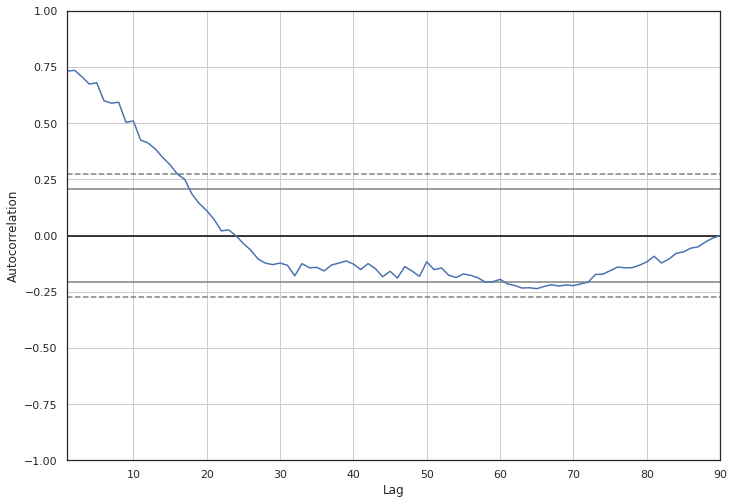

In [50]:
autocorrelation_plot(df.loc[:, "daily_inf"].fillna(0))

In [36]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from matplotlib import pyplot
df.index = pd.to_datetime(df.index)
series = pd.Series(df.loc[:, "zar"])

/home/pk/miniconda3/envs/corona-analysis-1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                    zar   No. Observations:                   77
Model:                ARIMA(10, 1, 0)   Log Likelihood                -434.900
Date:                Sun, 11 Jul 2021   AIC                            891.800
Time:                        20:44:47   BIC                            917.438
Sample:                    03-31-2020   HQIC                           902.046
                         - 05-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2797      0.096      2.923      0.003       0.092       0.467
ar.L2          0.3875      0.121      3.204      0.001       0.150       0.625
ar.L3          0.1111      0.170      0.652      0.5

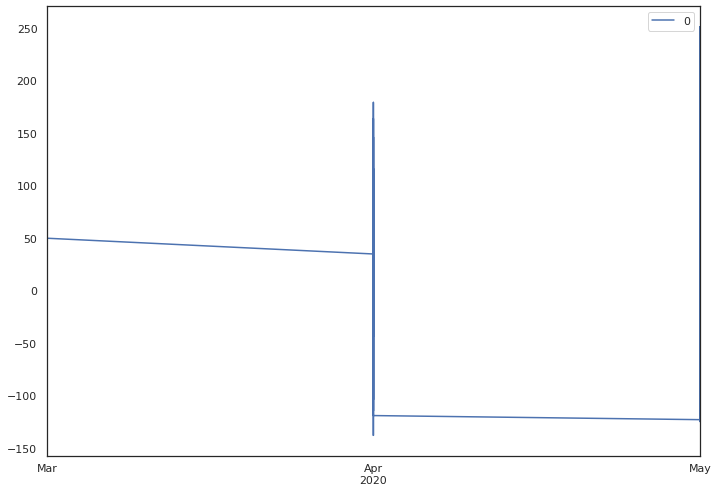

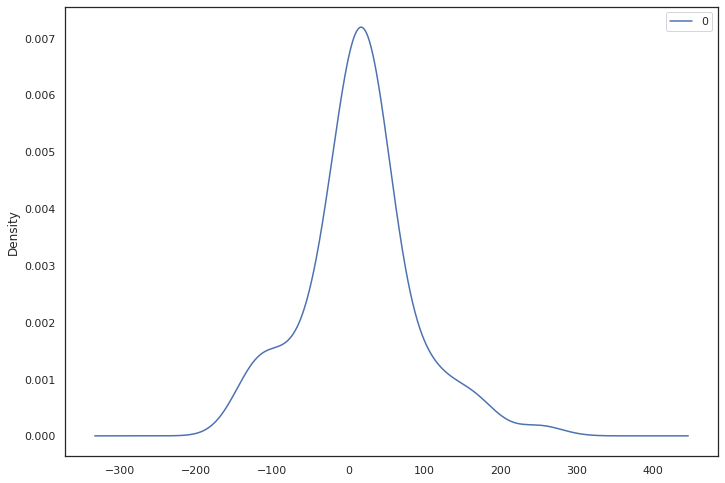

                0
count   77.000000
mean    14.572279
std     70.839854
min   -138.266728
25%    -13.565511
50%     14.875748
75%     39.552829
max    251.114475


In [90]:
series.index = series.index.to_period('M')
# fit model
model = ARIMA(series, order=(10,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [95]:
model_fit.forecast()

2026-08    19603.707474
Freq: M, dtype: float64